# Classification on Type Based on Summary Statistics

**On Type Classification**
Currently using f1...f16 different speed quantiles at different speed segments.
Large Param sweep area
BUT still very similar test set acc: 77%

In [1]:
import pandas as pd
import numpy as np
import torch
import warnings
import sys, os

sys.path.append(os.path.abspath('..'))

ais_tracks_path = '../../data/tracks_ais.csv'
cleaned_detections_path = '../../data/cleaned_data/preprocessed_radar_detections.csv'
ais_tracks = pd.read_csv(ais_tracks_path)
radar_detections = pd.read_csv(cleaned_detections_path)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

/Users/liuzehan/miniconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: mps


In [2]:
from core.sum_stats import SumStats2

sum_stats = SumStats2(radar_detections)
summary_df = sum_stats()

In [4]:
summary_df.columns

Index(['id_track', 'duration', 'detections', 'max_speed', 'min_speed',
       'avg_speed', 'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o', 'f1', 'f2', 'f3', 'f4',
       'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15',
       'f16'],
      dtype='object')

### Examine SumStats

In [4]:
import plotly.graph_objects as go


class DebugTrackPlotter:
    """
    Interactive Plotter for a single vessel track with hover and summary stats.
    Init Args:
        current_track: radar_detections corresponding to a single id_track
        ais_tracks: reference ais tracks
    """

    def __init__(self, current_track, ais_tracks):
        self.current_track = current_track
        self.ais_tracks = ais_tracks

    def plot_track(self):
        assert len(self.current_track['id_track'].unique()) == 1, "track_data must be associated with 1 track"
        num_detections = self.current_track.shape[0]
        current_assoc_id = self.current_track['assoc_id'].iloc[0]
        reference = self.ais_tracks[self.ais_tracks['id_track'] == current_assoc_id]

        # Compute per-point and summary stats
        group = SumStats.compute_track_features(self.current_track.copy())  # new helper below
        summary = SumStats.compute_track_stats(group)
        track_id = group['id_track'].iloc[0]

        # Format the title text
        summary_text = f"""
        <b>Track ID:</b> {track_id}<br>
        <b>Num Detections:</b>{num_detections}<br>
        <b>Vessel Type:<b> {reference['type_m2'].iloc[0]}<br><br>

        <b>Manual:</b><br>
        <b>Avg Speed:</b> {summary['avg_speed']:.2f} kn<br>
        <b>Max Speed:</b> {summary['max_speed']:.2f} kn<br>
        <b>Min Speed:</b> {summary['min_speed']:.2f} kn<br> 
        <b>Heading Mean:</b> {summary['heading_mean']:.2f}°<br>
        <b>Heading Std:</b> {summary['heading_std']:.2f}°<br>
        <b>Turning Mean:</b> {summary['turning_mean']:.2f}°<br>
        <b>Turning Std:</b> {summary['turning_std']:.2f}°<br><br>

        <b>AIS:</b><br>
        <b>Avg Speed:</b> {reference['avg_speed'].iloc[0]:.2f} kn<br>
        <b>Max Speed:</b> {reference['max_speed'].iloc[0]:.2f} kn<br>
        <b>Min Speed:</b> {reference['min_speed'].iloc[0]:.2f} kn<br>
        <b>Heading Mean:</b> {reference['heading_mean'].iloc[0]:.2f}°<br>
        <b>Heading Std:</b> {reference['heading_std'].iloc[0]:.2f}°<br>
        <b>Turning Mean:</b> {reference['turning_mean'].iloc[0]:.2f}°<br>
        <b>Turning Std:</b> {reference['turning_std'].iloc[0]:.2f}°
        """

        # Create hover text
        group['hover_text'] = (
            'Course: ' + group['course'].astype(str) +
            '<br>Speed: ' + group['speed'].astype(str) +
            '<br>Instant Speed (knots): ' + group['instant_speed'].round(2).astype(str) +
            '<br>Time Diff (s): ' + group['time_diff'].round(1).astype(str) +
            '<br>Heading Diff (°): ' + group['heading_diff'].round(2).astype(str)
        )

        fig = go.Figure()

        # Trajectory
        fig.add_trace(go.Scattergeo(
            lon=group['longitude'],
            lat=group['latitude'],
            mode='markers+lines',
            marker=dict(size=5, color='blue'),
            line=dict(width=1),
            text=group['hover_text'],
            hoverinfo='text',
            name='Trajectory'
        ))

        # Start point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[0]],
            lat=[group['latitude'].iloc[0]],
            mode='markers',
            marker=dict(size=10, color='green', symbol='triangle-up'),
            name='Start'
        ))

        # End point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[-1]],
            lat=[group['latitude'].iloc[-1]],
            mode='markers',
            marker=dict(size=10, color='red', symbol='triangle-down'),
            name='End'
        ))

        # Compute bounding box for automatic zoom
        min_lat, max_lat = group['latitude'].min(), group['latitude'].max()
        min_lon, max_lon = group['longitude'].min(), group['longitude'].max()
        center_lat = (min_lat + max_lat) / 2
        center_lon = (min_lon + max_lon) / 2

        # Estimate appropriate zoom/scale
        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        zoom_scale = max(lat_range, lon_range)
        zoom_scale = max(zoom_scale, 0.1)  # Avoid too tight zoom

        fig.update_layout(
            title=dict(text=summary_text, x=0.01, xanchor='left', yanchor='top',
                       font = dict(size = 12)),
            geo=dict(
                showland=True,
                landcolor='rgb(243, 243, 243)',
                countrycolor='rgb(204, 204, 204)',
                projection_type='equirectangular',
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                resolution=50,
                center=dict(lat=center_lat, lon=center_lon),
                lataxis=dict(range=[min_lat - 0.05, max_lat + 0.05]),
                lonaxis=dict(range=[min_lon - 0.05, max_lon + 0.05]),
            ),
            margin={"r":0, "t":100, "l":0, "b":0}
        )
        fig.show()

In [43]:
comparison[comparison['turning_mean_x'] >= 50]['id_track'].sample(10)

2600    31076261
2531    30932420
915     38373532
4950    37168803
2827    31804219
5420    38089939
4000    34663737
2608    31077759
2943    31996290
2512    30905012
Name: id_track, dtype: int64

In [44]:
debug_track = radar_detections[radar_detections['id_track'] ==31076261]
debug_plotter = DebugTrackPlotter(debug_track, ais_tracks)
debug_plotter.plot_track()


In [48]:
ais_tracks[ais_tracks['id_track'] == 31068366]['turning_mean']

2306    70.720396
Name: turning_mean, dtype: float64

### Plotting to Check Consistency

In [7]:
ais_tracks_best = ais_tracks.sort_values('assoc_str', ascending=False).drop_duplicates(subset='assoc_id', keep='first')

comparison = pd.merge(ais_tracks_best, summary_df, left_on = 'assoc_id', right_on = 'id_track', how = 'right')
comparison['turning_mean_x'].describe()

count    14068.000000
mean         9.025386
std         17.383309
min          0.110101
25%          0.749116
50%          2.296805
75%          7.738984
max        129.025517
Name: turning_mean_x, dtype: float64

/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


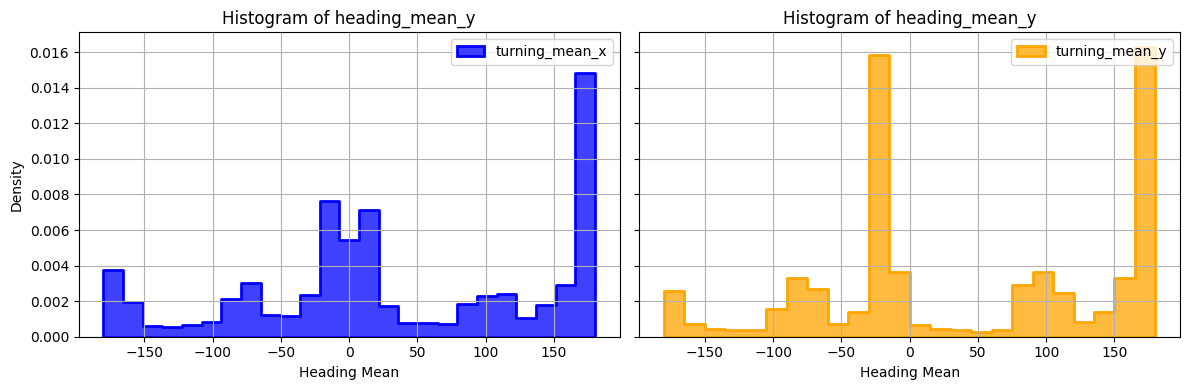

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['heading_mean_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='Heading_mean_x'
)
axes[0].set_title('Histogram of heading_mean_y')
axes[0].set_xlabel('Heading Mean')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['heading_mean_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='Heading_mean_y'
)
axes[1].set_title('Histogram of heading_mean_y')
axes[1].set_xlabel('Heading Mean')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


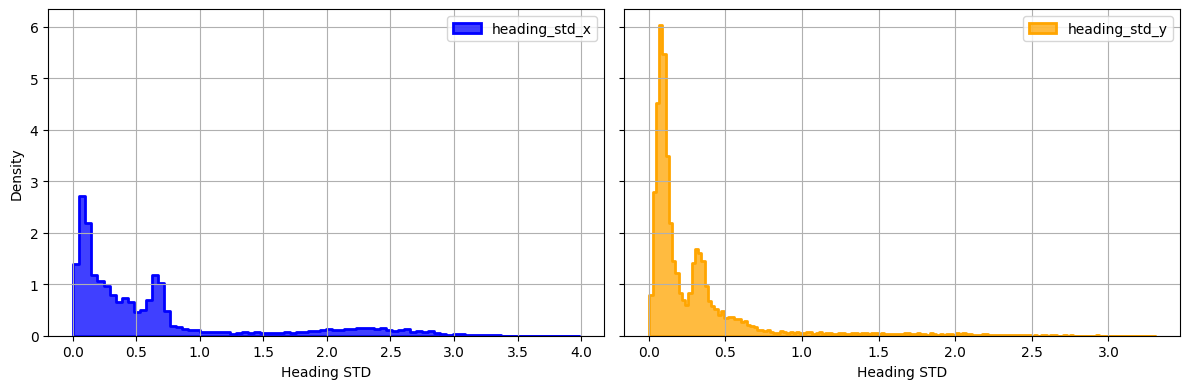

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['heading_std_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='heading_std_x'
)
axes[0].set_xlabel('Heading STD')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['heading_std_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='heading_std_y'
)
axes[1].set_xlabel('Heading STD')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


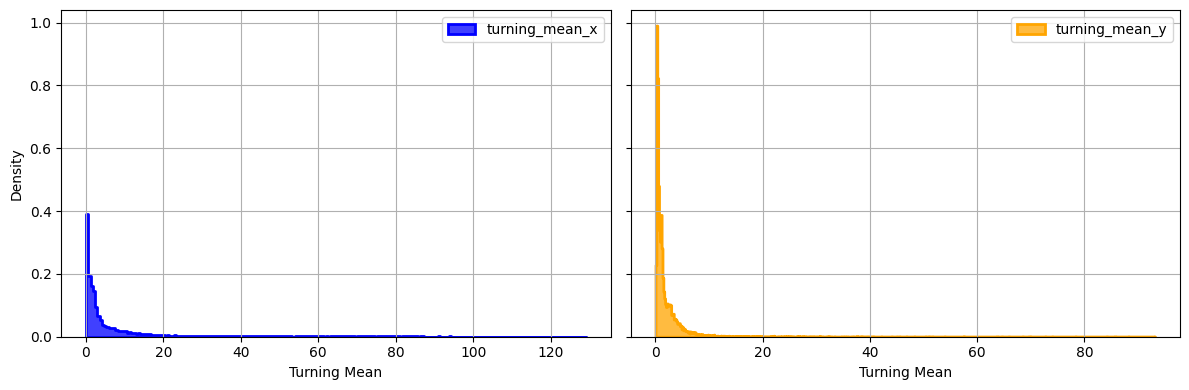

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['turning_mean_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='turning_mean_x'
)
axes[0].set_xlabel('Turning Mean')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['turning_mean_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='turning_mean_y'
)
axes[1].set_xlabel('Turning Mean')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


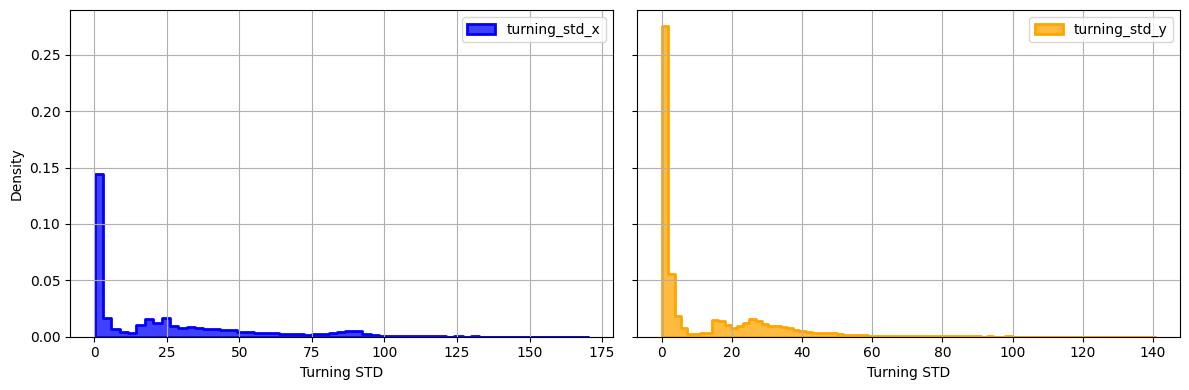

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['turning_std_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='turning_std_x'
)
axes[0].set_xlabel('Turning STD')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['turning_std_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='turning_std_y'
)
axes[1].set_xlabel('Turning STD')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


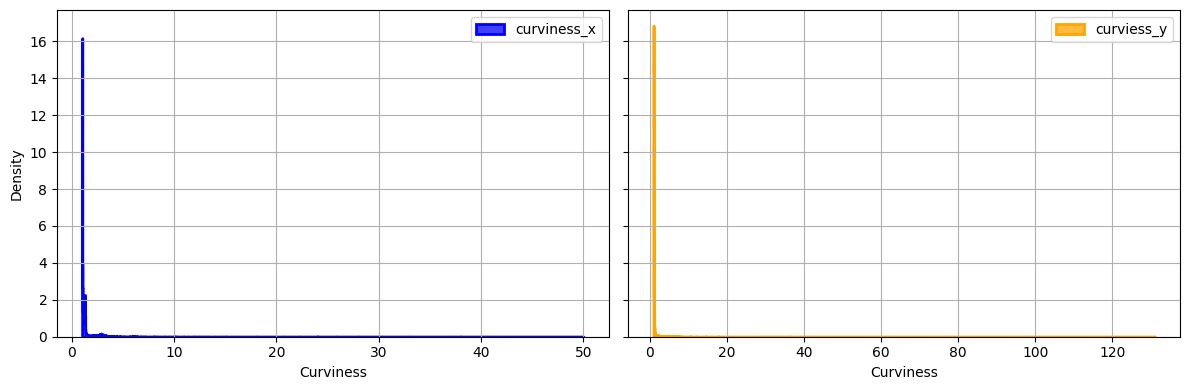

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['curviness_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='curviness_x'
)
axes[0].set_xlabel('Curviness')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['curviness_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='curviess_y'
)
axes[1].set_xlabel('Curviness')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


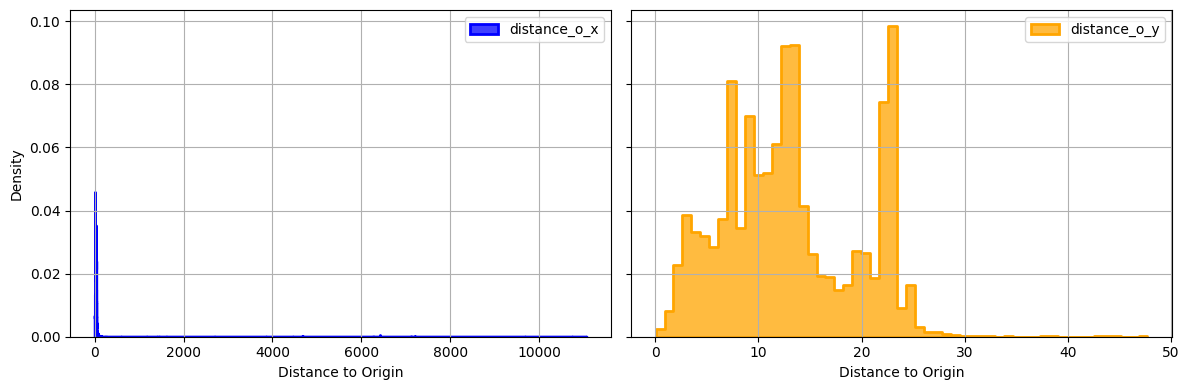

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for heading_mean_x
sns.histplot(
    comparison['distance_o_x'].dropna(),
    ax=axes[0],
    linewidth=2,
    element='step',
    stat='density',
    color='blue',
    label='distance_o_x'
)
axes[0].set_xlabel('Distance to Origin')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Plot for heading_mean_y
sns.histplot(
    comparison['distance_o_y'].dropna(),
    ax=axes[1],
    linewidth=2,
    element='step',
    stat='density',
    color='orange',
    label='distance_o_y'
)
axes[1].set_xlabel('Distance to Origin')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Type Classification

heading_mean really shouldn't be used: information leakage

In [13]:
# features_subset = ['max_speed_x',
#        'min_speed_x', 'avg_speed_x', 'curviness_x',
#        'heading_std_x', 'turning_mean_x', 'turning_std_x',
#        'distance_o_x']

# features_subset = ['max_speed_y',
#  'min_speed_y',
#  'avg_speed_y',
#  'curviness_y',
#  'heading_std_y',
#  'turning_mean_y',
#  'turning_std_y',
#  'distance_o_y']

features_subset = ['max_speed_y', 'min_speed_y', 'avg_speed_y', 'curviness_y',
       'heading_mean_y', 'heading_std_y', 'turning_mean_y', 'turning_std_y',
       'distance_total', 'distance_o_y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6',
       'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16']



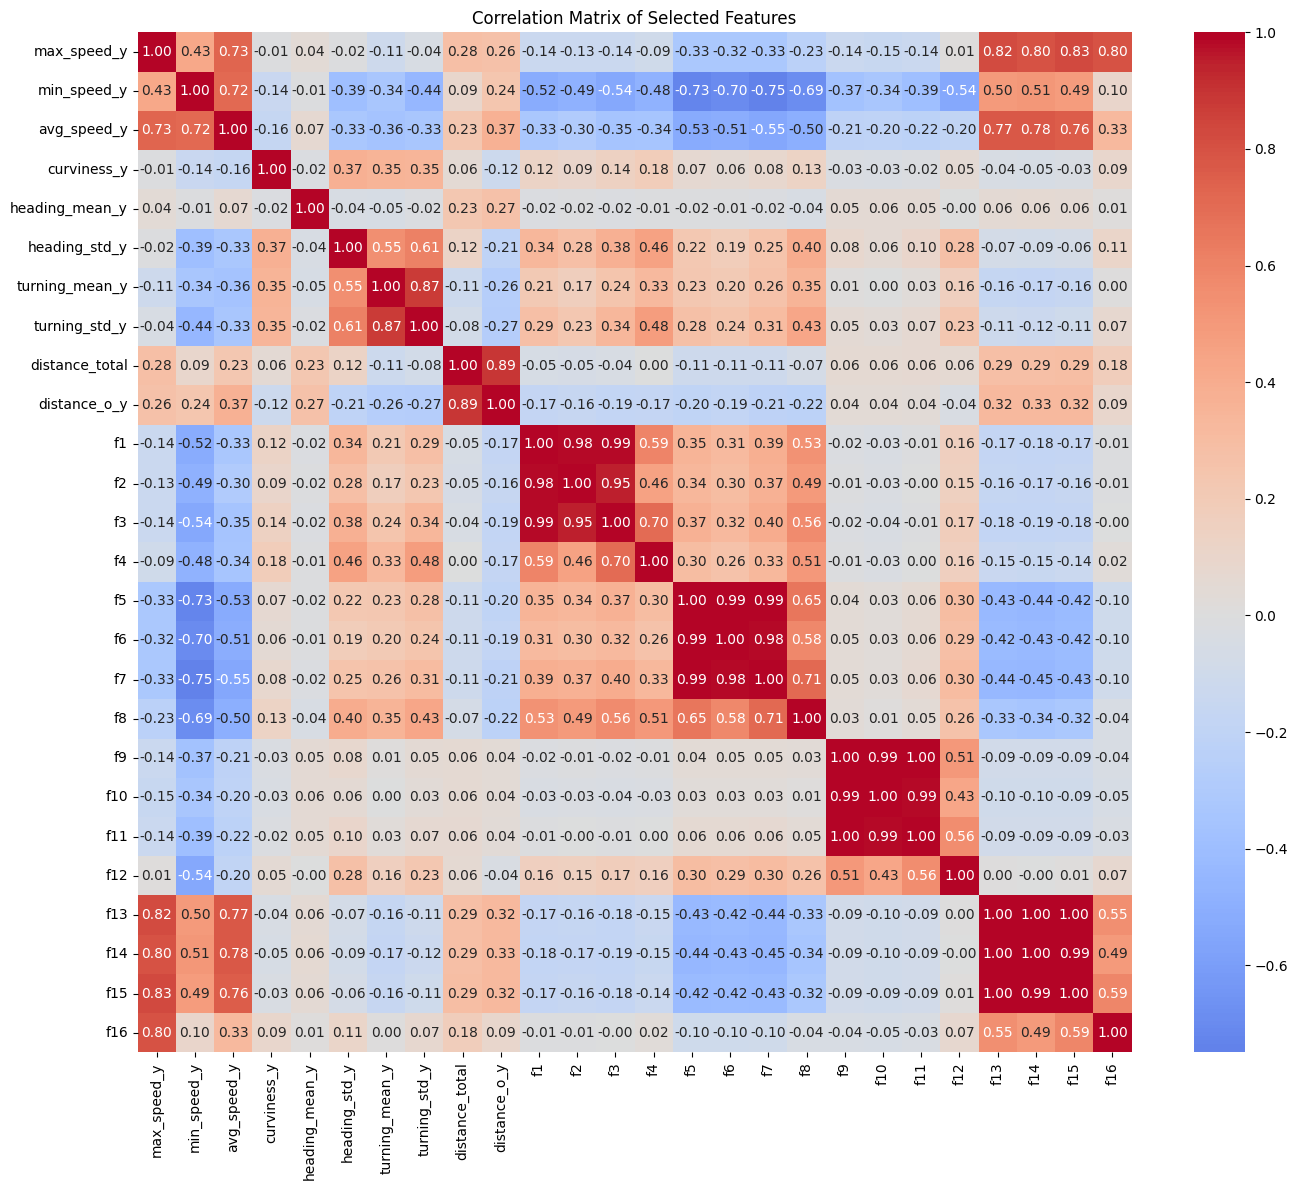

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = comparison[features_subset].corr()

# Plot using seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()


In [15]:
comparison.merge(ais_tracks[['assoc_id', 'type_m2']], left_on = 'id_track_y', right_on = 'assoc_id', how = 'inner')

from core.vessel_agg import VesselTypeAggregator

vessel_aggregator = VesselTypeAggregator()
vessel_aggregator.aggregate_vessel_type(comparison)

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import joblib
import json
import numpy as np

# Prepare features and target
X = comparison[features_subset]
y = comparison['type_m2_agg']

# Map labels to numeric
ship2num = {v: i for i, v in enumerate(y.unique())}
num2ship = {i: v for v, i in ship2num.items()}
y_numeric = y.map(ship2num)

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42
)

# Define base model
base_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

# Hyperparameter grid
param_grid = {
    'max_depth': [13, 16, 19],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# Manual grid search with cross-validation
best_score = -np.inf
best_params = None
results = []

for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid search progress"):
    model = base_model.set_params(**params)
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Train best model on full training set
best_model = base_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Best params:", best_params)
print("Best CV accuracy: {:.4f}".format(best_score))
print("Test Set Accuracy: {:.4f}".format(test_accuracy))

# Save model and results
joblib.dump(best_model, "xgb_best_model.pkl")

with open("xgb_results_summary.json", "w") as f:
    json.dump({
        "param_grid": param_grid,
        "best_params": best_params,
        "best_cv_accuracy": round(best_score, 4),
        "test_set_accuracy": round(test_accuracy, 4)
    }, f, indent=4)


Grid search progress:   0%|          | 0/243 [00:00<?, ?it/s]/Users/liuzehan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:23] WARNING: /Users/runner/work/xgboost/xgb

Best params: {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 5}
Best CV accuracy: 0.7853
Test Set Accuracy: 0.7754


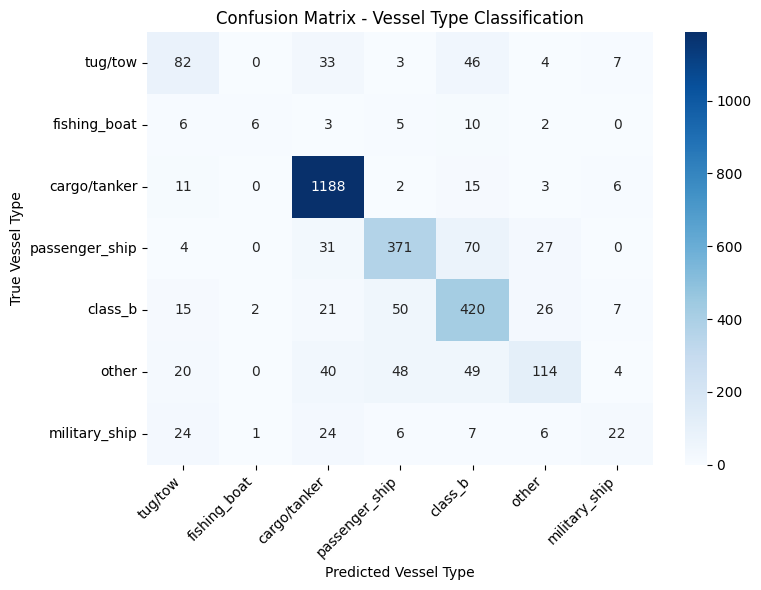

In [20]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(8, 6))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(ship2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(ship2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

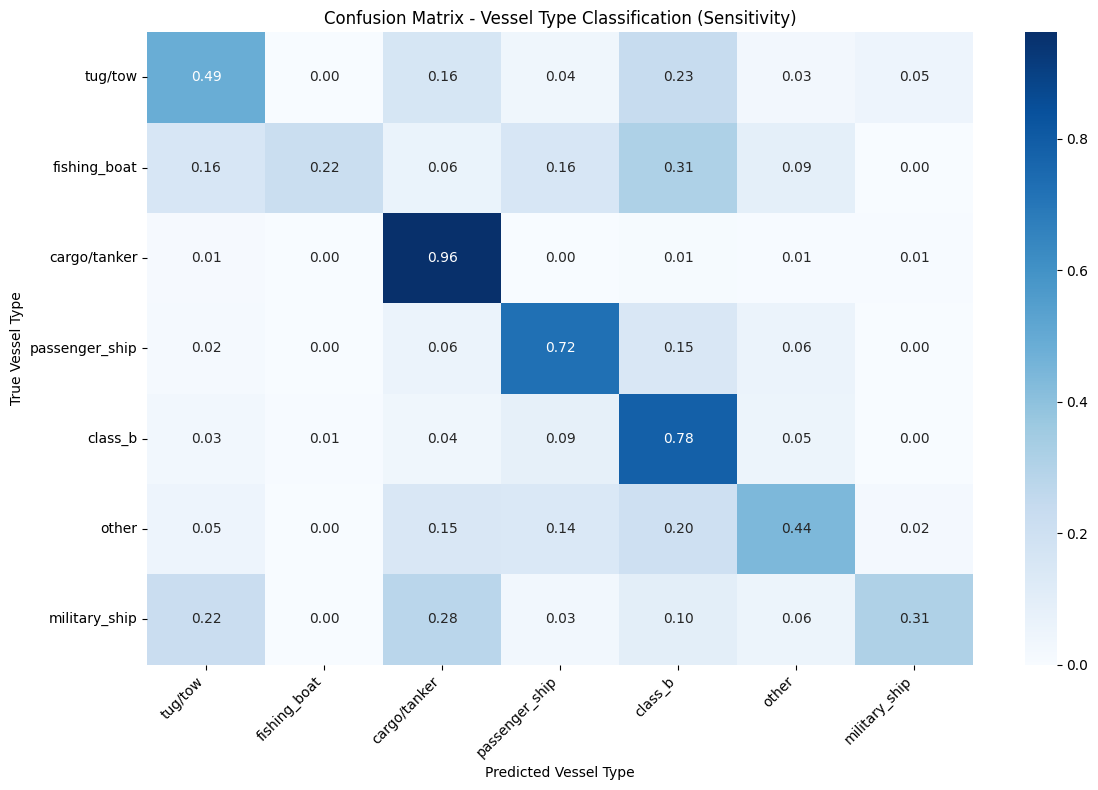

In [14]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification (Sensitivity)')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

<Figure size 1000x800 with 0 Axes>

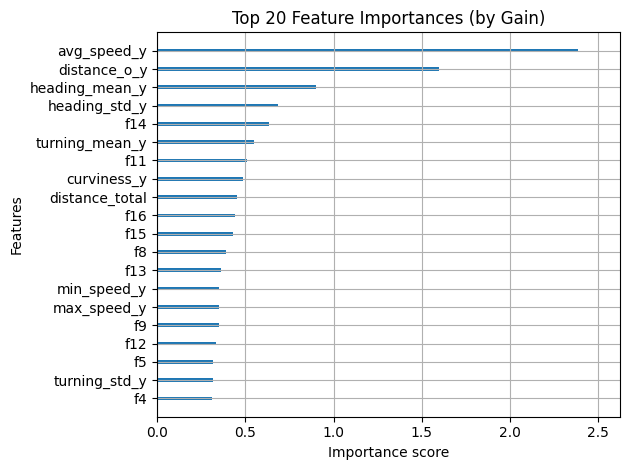

In [21]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Top 20 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()
